### Q_1 : Audio Loading & Signal Analysis

Sampling Rate: 44100
Samples: 5828927
Duration: 132.17521541950114
Max: 27759
Min: -30856


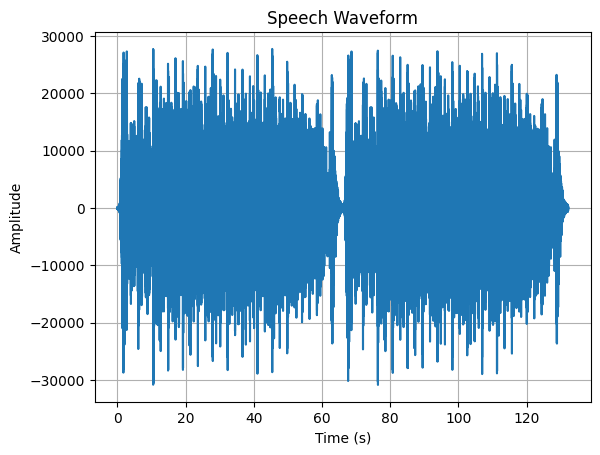

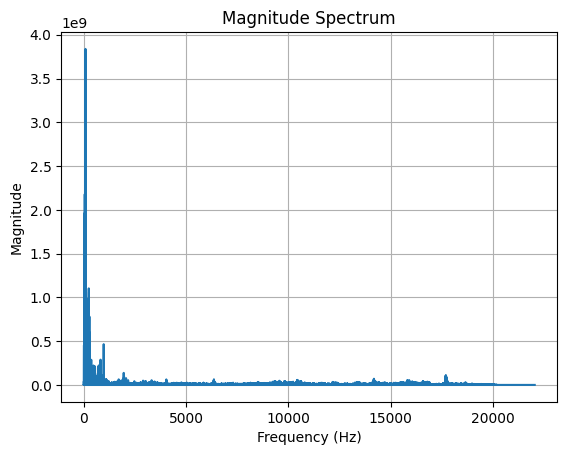

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

fs, x = wavfile.read("Sample-WAV-File.wav")
if x.ndim > 1:
    x = x[:,0]

N = len(x)
t = np.arange(N) / fs

print("Sampling Rate:", fs)
print("Samples:", N)
print("Duration:", N/fs)
print("Max:", np.max(x))
print("Min:", np.min(x))

plt.figure()
plt.plot(t, x)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Speech Waveform")
plt.grid()
plt.show()

X = np.abs(np.fft.fft(x))
f = np.fft.fftfreq(N, 1/fs)

plt.figure()
plt.plot(f[:N//2], X[:N//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum")
plt.grid()
plt.show()

### Q2: Framing & Windowing (From Scratch)

Total Frames: 13216


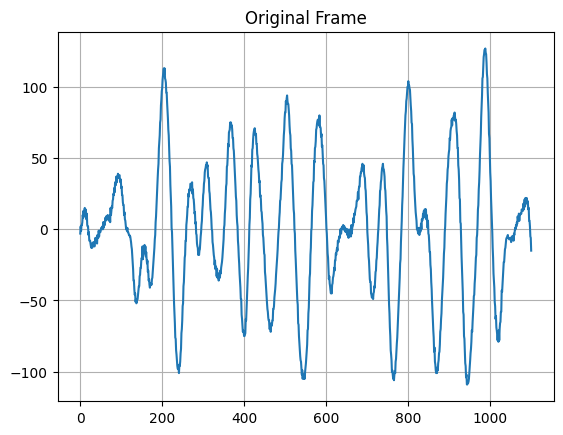

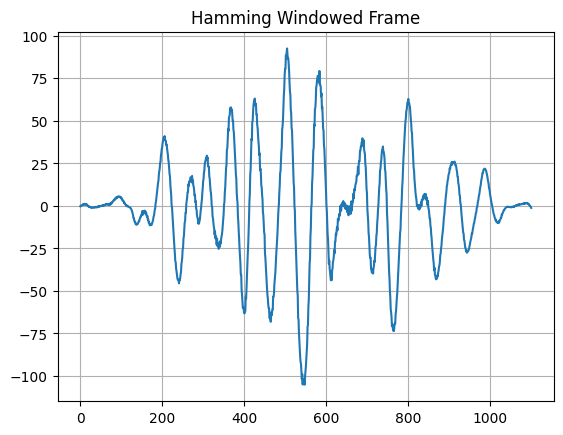

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

fs, x = wavfile.read("Sample-WAV-File.wav")
if x.ndim > 1:
    x = x[:,0]

frame_len = int(0.025 * fs)
frame_step = int(0.010 * fs)

num_frames = 1 + int((len(x) - frame_len) / frame_step)
print("Total Frames:", num_frames)

frames = np.array([
    x[i*frame_step : i*frame_step + frame_len]
    for i in range(num_frames)
])

hamming = 0.54 - 0.46*np.cos(2*np.pi*np.arange(frame_len)/(frame_len-1))
win_frames = frames * hamming

plt.figure()
plt.plot(frames[5])
plt.title("Original Frame")
plt.grid()
plt.show()

plt.figure()
plt.plot(win_frames[5])
plt.title("Hamming Windowed Frame")
plt.grid()
plt.show()

### Q3: STFT & Spectrogram

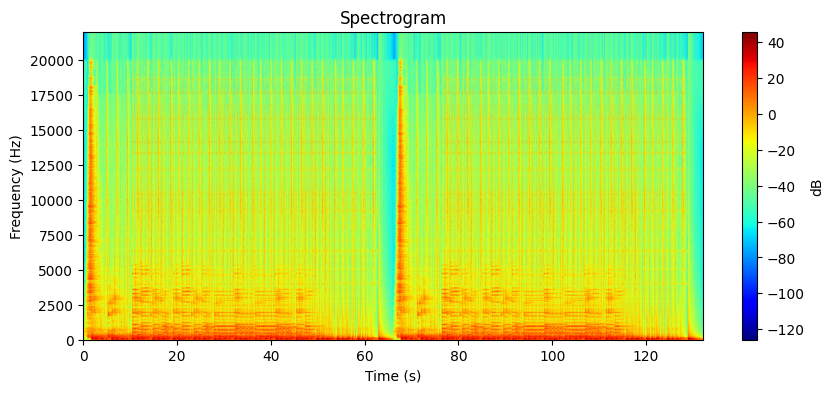

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

fs, x = wavfile.read("Sample-WAV-File.wav")
if x.ndim > 1:
    x = x[:,0]
x = x / np.max(np.abs(x))

frame_len = int(0.025 * fs)
frame_step = int(0.010 * fs)
window = np.hamming(frame_len)

frames = [
    x[i*frame_step : i*frame_step + frame_len] * window
    for i in range(1 + int((len(x)-frame_len)/frame_step))
]

S = np.abs(np.fft.rfft(frames))
S_db = 20*np.log10(S + 1e-8)

plt.figure(figsize=(10,4))
plt.imshow(S_db.T, aspect='auto', origin='lower',
           extent=[0,len(x)/fs,0,fs/2], cmap='jet')
plt.colorbar(label="dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")
plt.show()

### Q4: MFCC Extraction

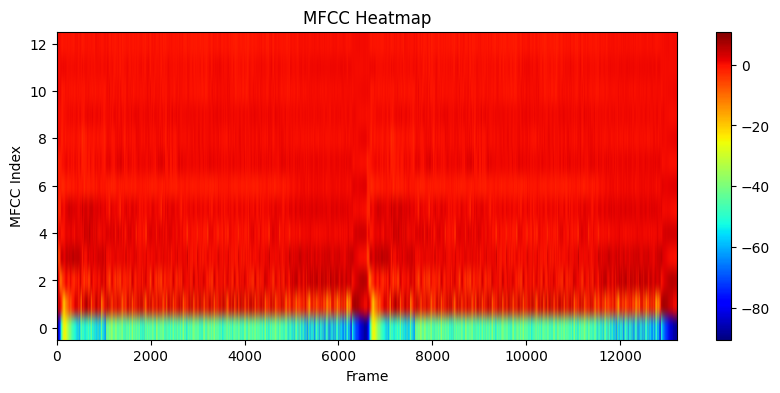

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import dct

fs, x = wavfile.read("Sample-WAV-File.wav")
if x.ndim > 1:
    x = x[:,0]
x = x / np.max(np.abs(x))

# Pre-emphasis
x = np.append(x[0], x[1:] - 0.97*x[:-1])

frame_len = int(0.025 * fs)
frame_step = int(0.010 * fs)
NFFT = 512
nfilt = 26

frames = np.array([
    x[i*frame_step : i*frame_step + frame_len]
    for i in range(1 + int((len(x)-frame_len)/frame_step))
])
frames *= np.hamming(frame_len)

pow_spec = (np.abs(np.fft.rfft(frames, NFFT))**2) / NFFT

mel = np.linspace(0, 2595*np.log10(1+fs/1400), nfilt+2)
hz = 700*(10**(mel/2595)-1)
bins = np.floor((NFFT+1)*hz/fs).astype(int)

fb = np.zeros((nfilt, NFFT//2+1))
for m in range(1, nfilt+1):
    fb[m-1, bins[m-1]:bins[m]] = np.linspace(0,1,bins[m]-bins[m-1])
    fb[m-1, bins[m]:bins[m+1]] = np.linspace(1,0,bins[m+1]-bins[m])

mel_energy = np.dot(pow_spec, fb.T)
mfcc = dct(np.log(mel_energy+1e-8), axis=1, norm='ortho')[:, :13]

plt.figure(figsize=(10,4))
plt.imshow(mfcc.T, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.xlabel("Frame")
plt.ylabel("MFCC Index")
plt.title("MFCC Heatmap")
plt.show()

### Q5: Pitch Detection (Autocorrelation)

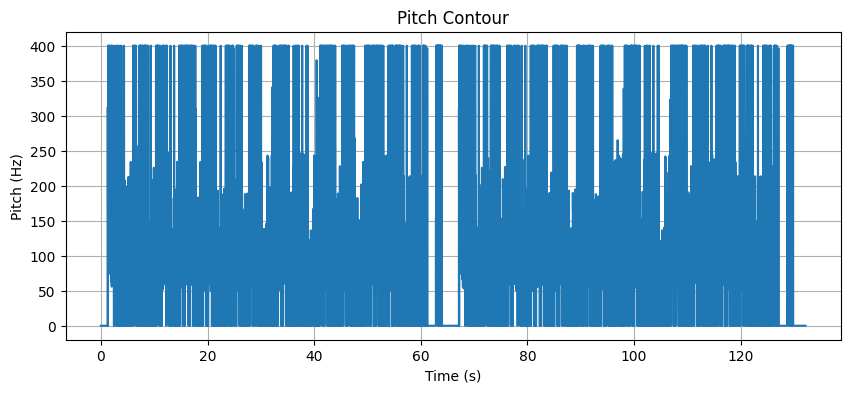

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

fs, x = wavfile.read("Sample-WAV-File.wav")
if x.ndim > 1:
    x = x[:,0]
x = x / np.max(np.abs(x))

frame_len = int(0.025 * fs)
frame_step = int(0.010 * fs)

f0, time = [], []

for i in range(1 + int((len(x)-frame_len)/frame_step)):
    frame = x[i*frame_step : i*frame_step + frame_len]
    energy = np.mean(frame**2)
    
    if energy < 0.01:
        f0.append(0)
    else:
        r = np.correlate(frame, frame, mode='full')[frame_len:]
        lag = np.argmax(r[int(fs/400):int(fs/50)]) + int(fs/400)
        f0.append(fs/lag)
        
    time.append((i*frame_step)/fs)

plt.figure(figsize=(10,4))
plt.plot(time, f0)
plt.xlabel("Time (s)")
plt.ylabel("Pitch (Hz)")
plt.title("Pitch Contour")
plt.grid()    
plt.show()